In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import copy

In [4]:
# Load the dataset
df = pd.read_csv('Indian_IPO_Market_Data.csv')

# Display the first five rows
print("First 5 rows:")
display(df.head())

# Display the last five rows
print("Last 5 rows:")
display(df.tail())

# Print the shape of the dataset
print("Dataset shape (rows, columns):")
print(df.shape)

# Display dataset information
print("\nDataset info:")
df.info()

# Summary statistics for Listing_Gains_Percent
print("\nSummary statistics for Listing_Gains_Percent:")
print(df['Listing_Gains_Percent'].describe())

# Summary statistics for all numeric columns
print("\nSummary statistics for all numeric columns:")
print(df.describe())


First 5 rows:


,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,11.82
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,-84.21
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,17.13
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,-11.28
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,-5.20


Last 5 rows:


,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
314,26/08/22,Syrma SGS,840.13,42.42,7.13,2.84,15.59,220,42.30
315,06/09/22,Dreamfolks Serv,562.10,27.48,14.18,24.19,23.25,326,41.92
316,15/09/22,TMB,792.00,0.51,1.77,3.44,1.39,525,-3.15
317,26/09/22,Harsha Engineer,755.00,113.82,40.36,12.44,47.19,330,47.24
318,17/10/22,Electronics Mar,500.00,58.81,15.39,8.27,24.23,59,43.14


Dataset shape (rows, columns):
(319, 9)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   319 non-null    object 
 1   IPOName                319 non-null    object 
 2   Issue_Size             319 non-null    float64
 3   Subscription_QIB       319 non-null    float64
 4   Subscription_HNI       319 non-null    float64
 5   Subscription_RII       319 non-null    float64
 6   Subscription_Total     319 non-null    float64
 7   Issue_Price            319 non-null    int64  
 8   Listing_Gains_Percent  319 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 22.6+ KB

Summary statistics for Listing_Gains_Percent:
count    319.000000
mean       4.742696
std       47.650946
min      -97.150000
25%      -11.555000
50%        1.810000
75%       25.310000
max      270.400000

In [5]:
# Create binary target: 1 if listing gains are positive, else 0
df['Listing_Gains_Profit'] = (df['Listing_Gains_Percent'] > 0).astype(int)

# Preview the new column
df[['Listing_Gains_Percent', 'Listing_Gains_Profit']].head()


,Listing_Gains_Percent,Listing_Gains_Profit
0,11.82,1
1,-84.21,0
2,17.13,1
3,-11.28,0
4,-5.20,0


In [6]:
# Distribution of the target variable
target_counts = df['Listing_Gains_Profit'].value_counts()
print("Target distribution:")
print(target_counts)

# Percentage of profitable IPOs
profit_percentage = (target_counts[1] / target_counts.sum()) * 100
print(f"\nPercentage of profitable IPOs: {profit_percentage:.2f}%")


Target distribution:
Listing_Gains_Profit
1    174
0    145
Name: count, dtype: int64

Percentage of profitable IPOs: 54.55%


In [7]:
# Business Insight:
# If a large percentage of IPOs are profitable, investors face lower downside risk,
# but identifying the minority of losing IPOs becomes critical to avoid losses.
# If profitable IPOs are rare, this prediction task becomes even more valuable,
# as accurately identifying winning IPOs can generate significant alpha for investors.

In [8]:
# Columns that should NOT be used as predictors
columns_to_drop = ['Date', 'IPOName', 'Listing_Gains_Percent']

print("Columns to exclude from features:")
print(columns_to_drop)

Columns to exclude from features:
['Date', 'IPOName', 'Listing_Gains_Percent']


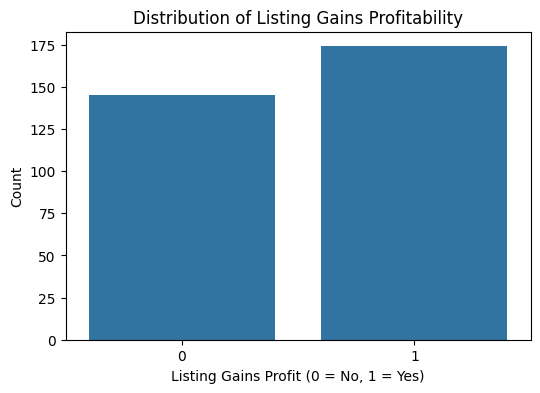

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Listing_Gains_Profit', data=df)
plt.title('Distribution of Listing Gains Profitability')
plt.xlabel('Listing Gains Profit (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [10]:
feature_columns = [
    'Issue_Size',
    'Subscription_QIB',
    'Subscription_HNI',
    'Subscription_RII',
    'Subscription_Total',
    'Issue_Price'
]

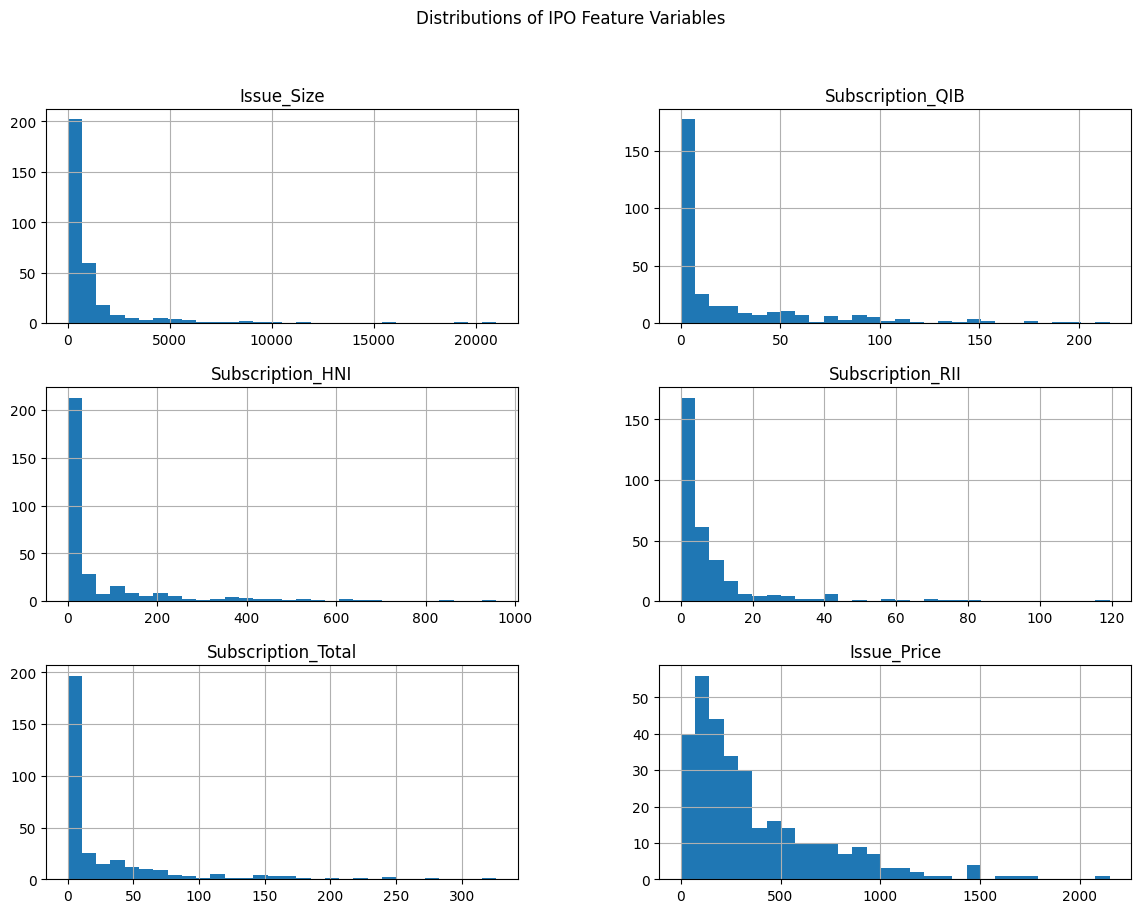

In [11]:
df[feature_columns].hist(bins=30, figsize=(14, 10))
plt.suptitle('Distributions of IPO Feature Variables')
plt.show()

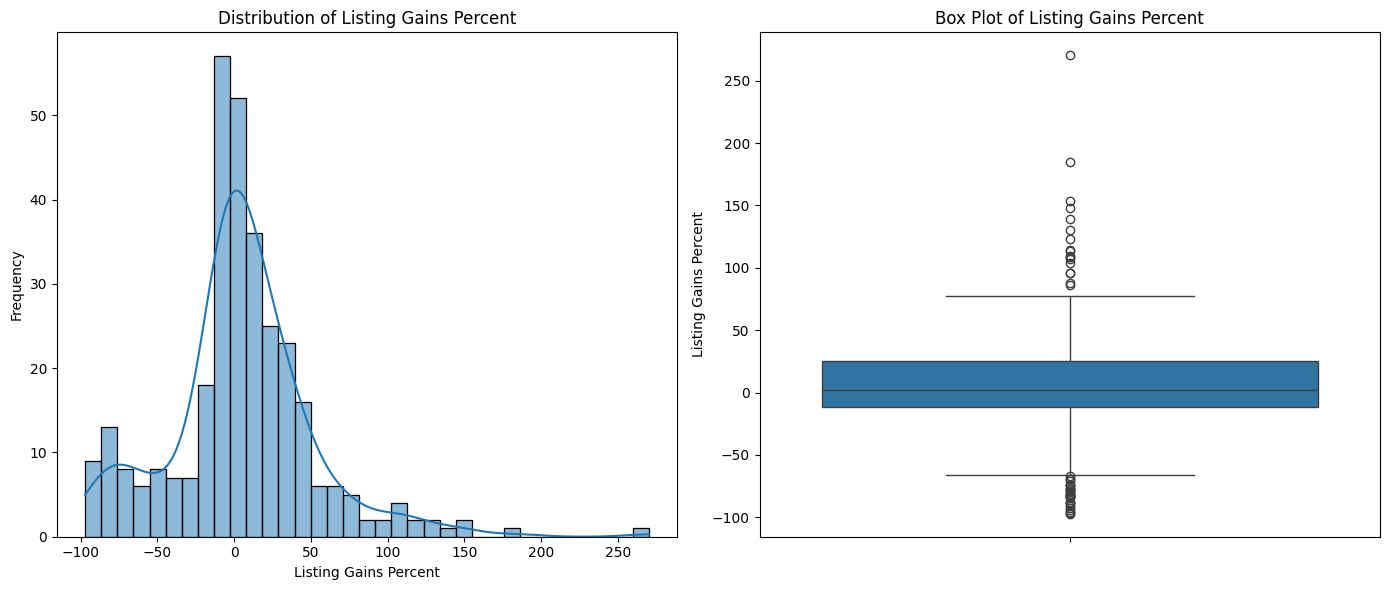


Mean Listing Gains Percent: 4.74%
Median Listing Gains Percent: 1.81%
Standard Deviation of Listing Gains Percent: 47.65%
Percentage of Profitable IPOs: 54.55%
Percentage of Non-Profitable IPOs: 45.45%


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
sns.histplot(df['Listing_Gains_Percent'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Listing Gains Percent')
axes[0].set_xlabel('Listing Gains Percent')
axes[0].set_ylabel('Frequency')

# Box Plot
sns.boxplot(y=df['Listing_Gains_Percent'], ax=axes[1])
axes[1].set_title('Box Plot of Listing Gains Percent')
axes[1].set_ylabel('Listing Gains Percent')

plt.tight_layout()
plt.show()

# Calculate key statistics
mean_gains = df['Listing_Gains_Percent'].mean()
median_gains = df['Listing_Gains_Percent'].median()
std_gains = df['Listing_Gains_Percent'].std()

# Calculate profit/loss percentages
total_ipos = len(df)
profitable_ipos = df[df['Listing_Gains_Percent'] > 0].shape[0]
non_profitable_ipos = total_ipos - profitable_ipos

profit_percentage = (profitable_ipos / total_ipos) * 100
non_profit_percentage = (non_profitable_ipos / total_ipos) * 100

print(f"\nMean Listing Gains Percent: {mean_gains:.2f}%")
print(f"Median Listing Gains Percent: {median_gains:.2f}%")
print(f"Standard Deviation of Listing Gains Percent: {std_gains:.2f}%")
print(f"Percentage of Profitable IPOs: {profit_percentage:.2f}%")
print(f"Percentage of Non-Profitable IPOs: {non_profit_percentage:.2f}%")

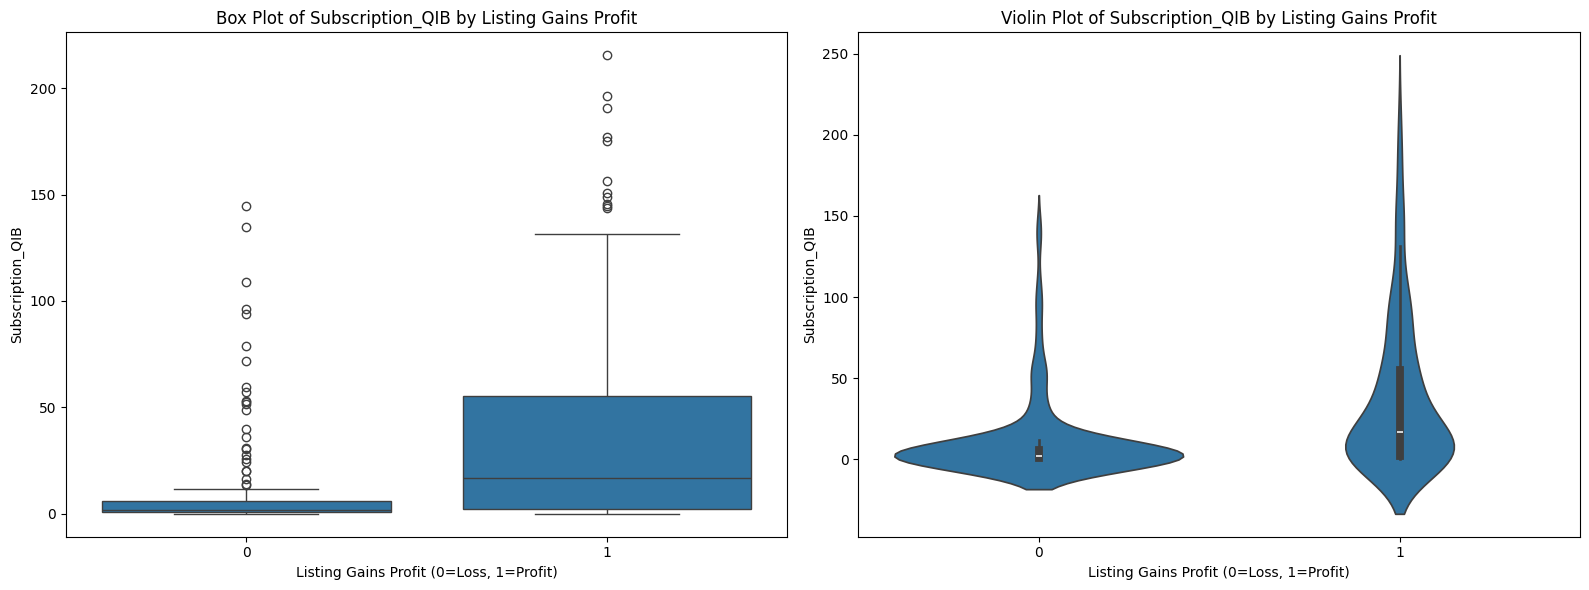

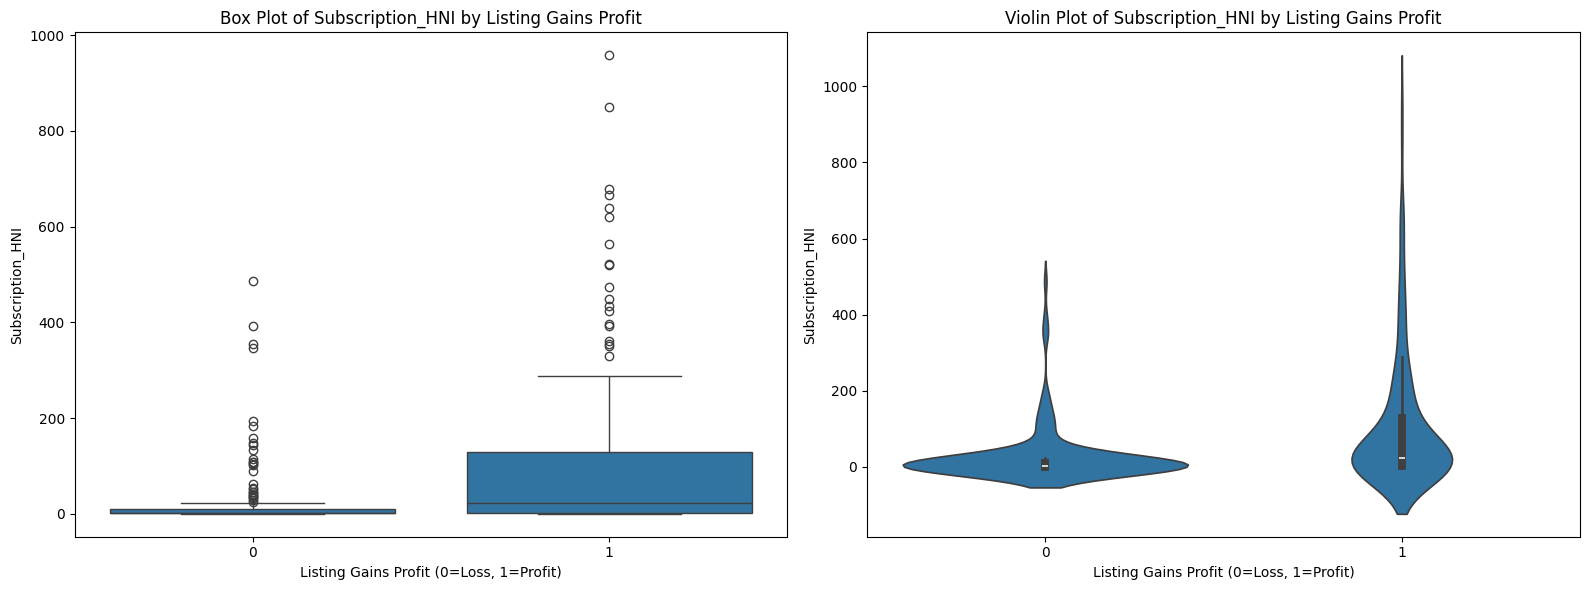

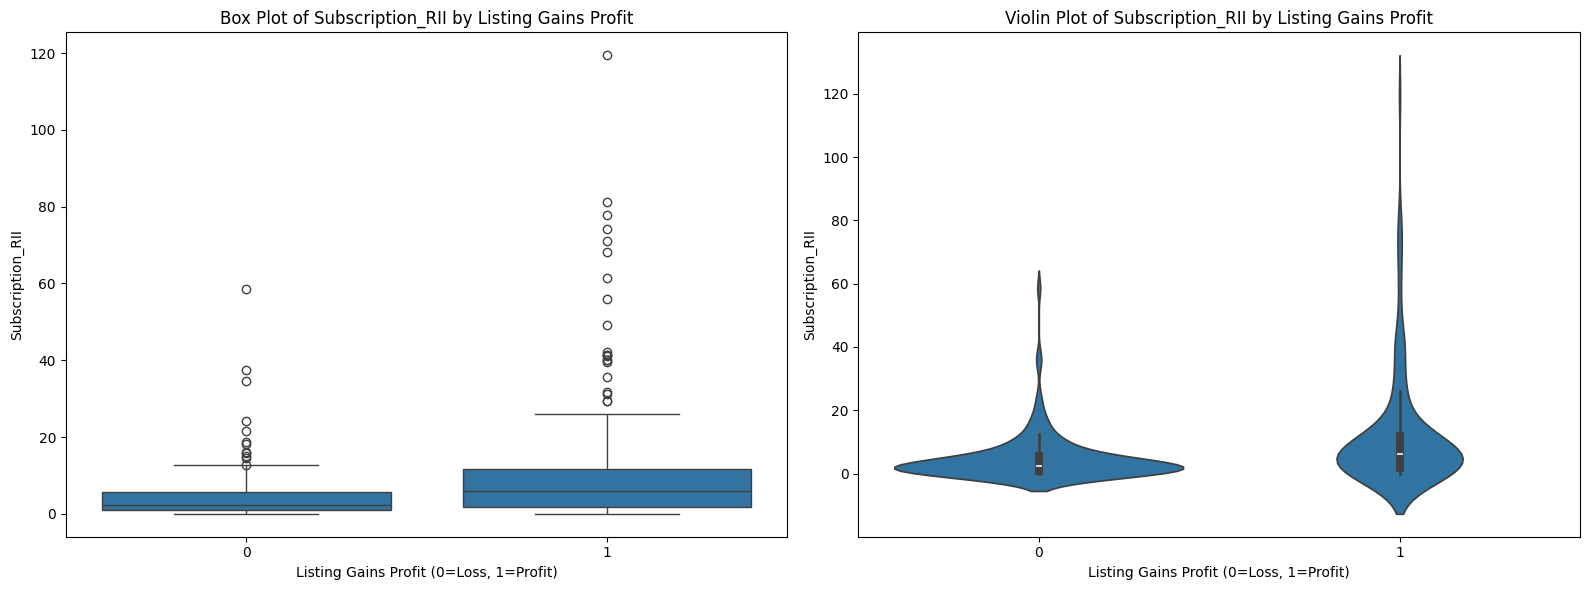

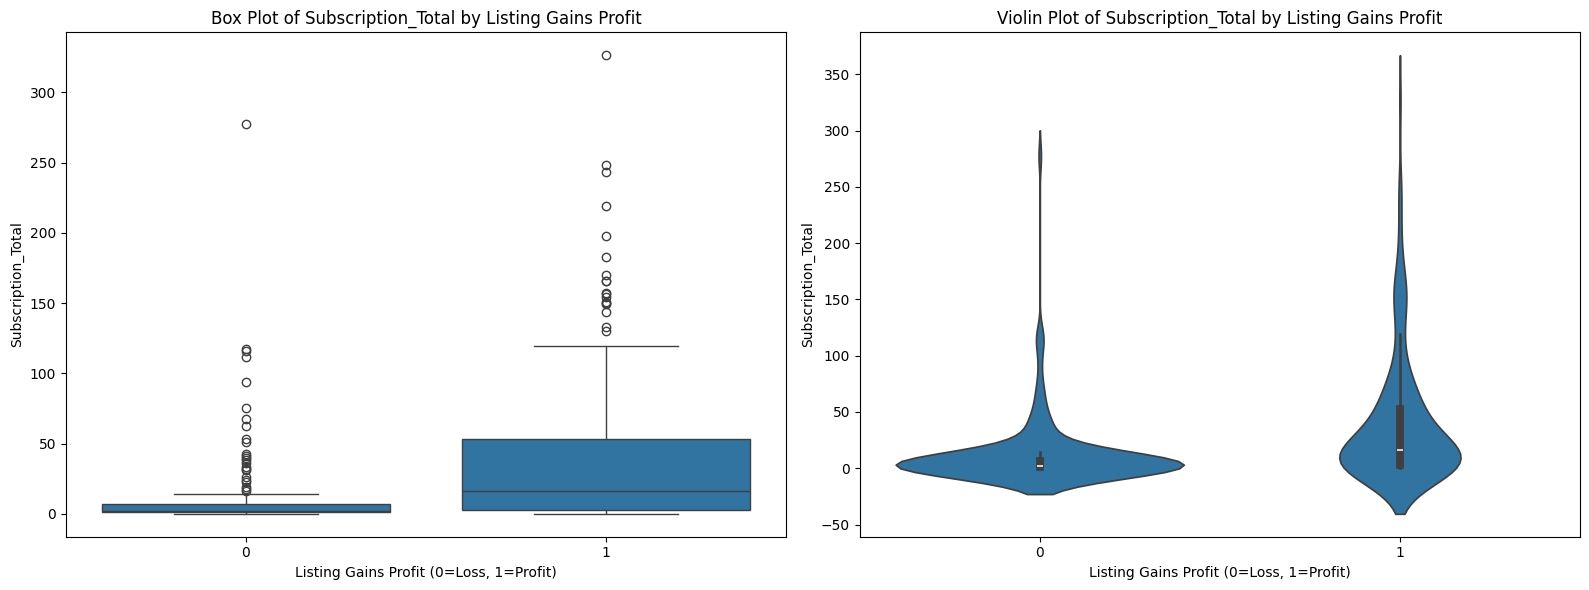


--- Mean Subscription Rates by Listing Gains Profit ---

Subscription_QIB:
  Mean for Non-Profitable IPOs (0): 11.28
  Mean for Profitable IPOs (1): 37.69

Subscription_HNI:
  Mean for Non-Profitable IPOs (0): 27.73
  Mean for Profitable IPOs (1): 105.39

Subscription_RII:
  Mean for Non-Profitable IPOs (0): 4.74
  Mean for Profitable IPOs (1): 11.75

Subscription_Total:
  Mean for Non-Profitable IPOs (0): 12.33
  Mean for Profitable IPOs (1): 40.04


In [13]:
subscription_columns = [
    'Subscription_QIB',
    'Subscription_HNI',
    'Subscription_RII',
    'Subscription_Total'
]

# Generate plots for each subscription column
for col in subscription_columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Box Plot
    sns.boxplot(x='Listing_Gains_Profit', y=col, data=df, ax=axes[0])
    axes[0].set_title(f'Box Plot of {col} by Listing Gains Profit')
    axes[0].set_xlabel('Listing Gains Profit (0=Loss, 1=Profit)')
    axes[0].set_ylabel(col)

    # Violin Plot
    sns.violinplot(x='Listing_Gains_Profit', y=col, data=df, ax=axes[1])
    axes[1].set_title(f'Violin Plot of {col} by Listing Gains Profit')
    axes[1].set_xlabel('Listing Gains Profit (0=Loss, 1=Profit)')
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

# Calculate and print mean subscription rates for each profit category
print("\n--- Mean Subscription Rates by Listing Gains Profit ---")
for col in subscription_columns:
    mean_subscription = df.groupby('Listing_Gains_Profit')[col].mean()
    print(f"\n{col}:")
    print(f"  Mean for Non-Profitable IPOs (0): {mean_subscription[0]:.2f}")
    print(f"  Mean for Profitable IPOs (1): {mean_subscription[1]:.2f}")

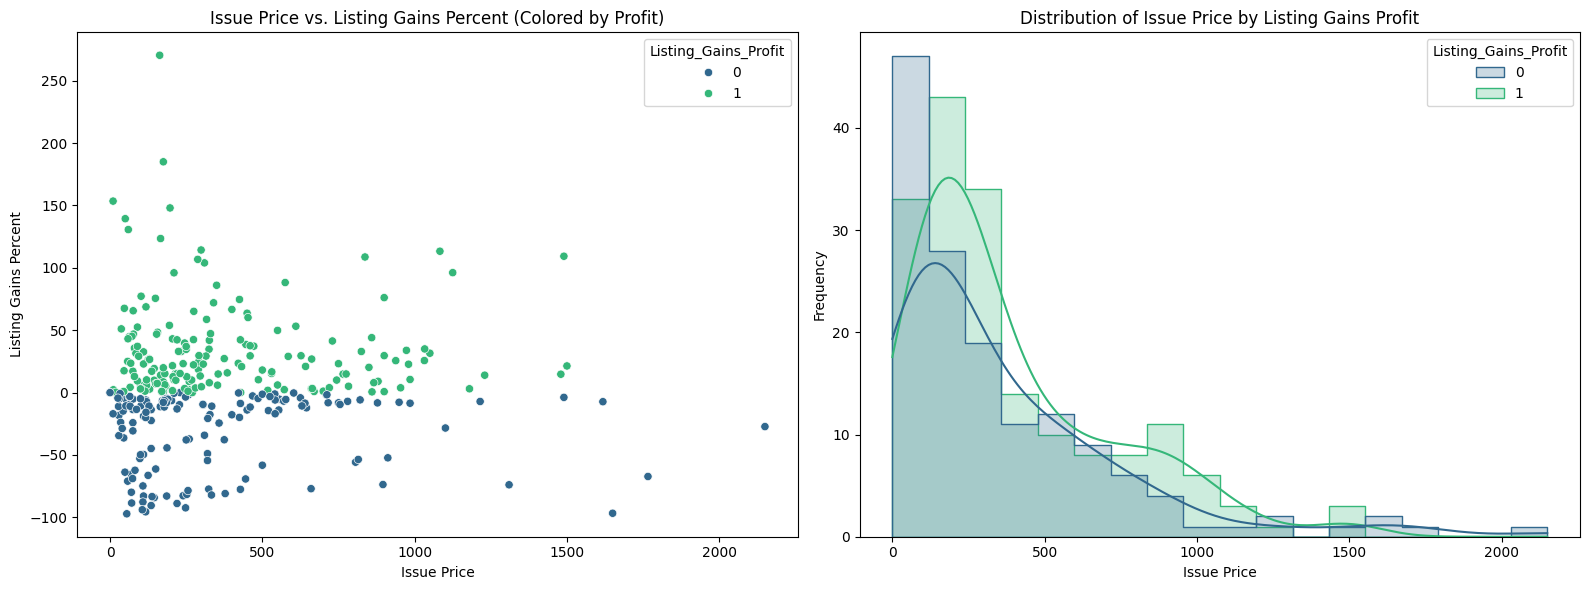

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot for Issue_Price vs. Listing_Gains_Percent
sns.scatterplot(
    x='Issue_Price',
    y='Listing_Gains_Percent',
    hue='Listing_Gains_Profit',
    data=df,
    ax=axes[0],
    palette='viridis'
)
axes[0].set_title('Issue Price vs. Listing Gains Percent (Colored by Profit)')
axes[0].set_xlabel('Issue Price')
axes[0].set_ylabel('Listing Gains Percent')

# Histogram for Issue_Price segmented by Listing_Gains_Profit
sns.histplot(
    x='Issue_Price',
    hue='Listing_Gains_Profit',
    data=df,
    kde=True,
    element='step',
    ax=axes[1],
    palette='viridis'
)
axes[1].set_title('Distribution of Issue Price by Listing Gains Profit')
axes[1].set_xlabel('Issue Price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [15]:
numerical_features_for_correlation = feature_columns + ['Listing_Gains_Percent']

print("Numerical features selected for correlation analysis:")
print(numerical_features_for_correlation)

Numerical features selected for correlation analysis:
['Issue_Size', 'Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total', 'Issue_Price', 'Listing_Gains_Percent']


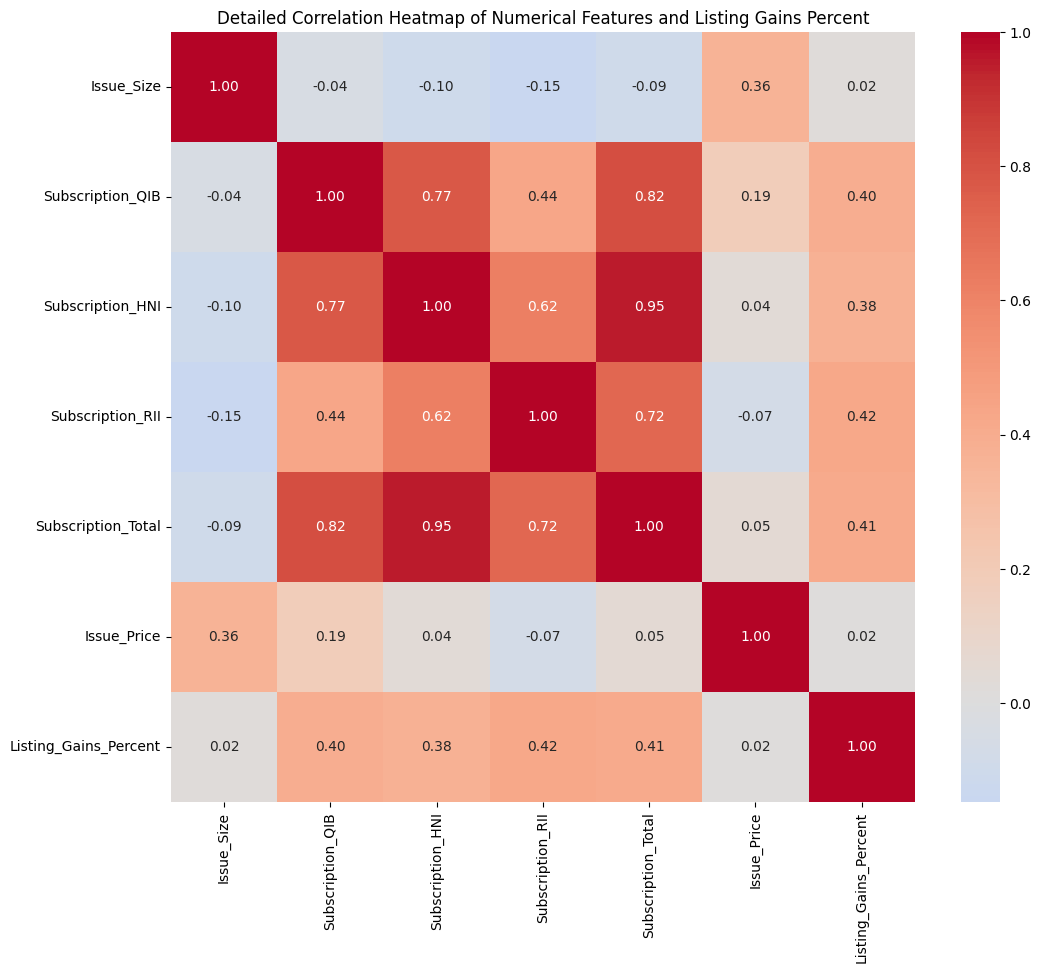

In [16]:
correlation_matrix_detailed = df[numerical_features_for_correlation].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix_detailed,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f"
)
plt.title('Detailed Correlation Heatmap of Numerical Features and Listing Gains Percent')
plt.show()

In [17]:
df = pd.read_csv('Indian_IPO_Market_Data.csv')

print("Columns after initial CSV load:")
print(df.columns)

# Check if 'Date' column exists, if not, try to find a similar one and rename
if 'Date' not in df.columns:
    # Attempt to find a column that might be 'Date' but with extra spaces, etc.
    date_col = next((col for col in df.columns if 'date' in col.lower()), None)
    if date_col and date_col != 'Date':
        df.rename(columns={date_col: 'Date'}, inplace=True)
        print(f"Renamed column '{date_col}' to 'Date'.")
    else:
        print("Error: 'Date' column not found and no similar column could be identified for renaming.")
        # If still not found, re-raise the error or handle it as appropriate

df['Listing_Gains_Profit'] = (df['Listing_Gains_Percent'] > 0).astype(int)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%y', errors='coerce')

# Sort the DataFrame by Date
df = df.sort_values(by='Date')

print("\nDataFrame reloaded, 'Date' column converted to datetime and sorted:")
print(df['Date'].head())

Columns after initial CSV load:
Index(['Date ', 'IPOName', 'Issue_Size', 'Subscription_QIB',
       'Subscription_HNI', 'Subscription_RII', 'Subscription_Total',
       'Issue_Price', 'Listing_Gains_Percent'],
      dtype='object')
Renamed column 'Date ' to 'Date'.

DataFrame reloaded, 'Date' column converted to datetime and sorted:
0   2010-02-03
1   2010-02-08
2   2010-02-15
3   2010-02-15
4   2010-02-19
Name: Date, dtype: datetime64[ns]


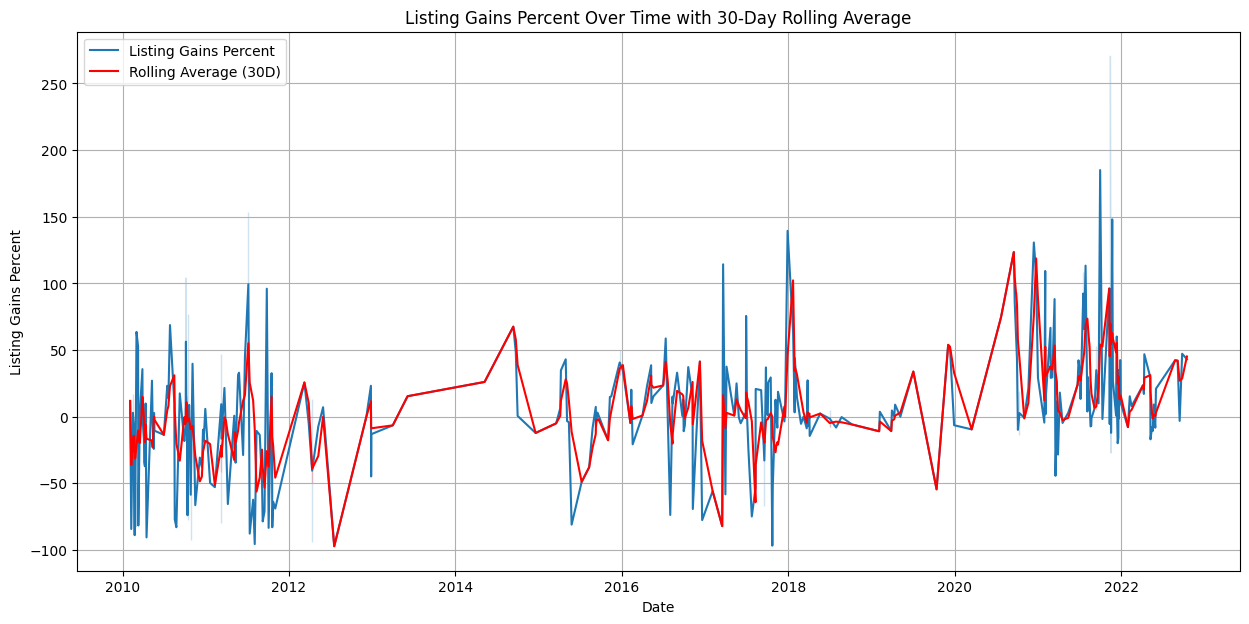

Rolling average of Listing_Gains_Percent calculated and plotted.


In [18]:
df['Listing_Gains_Percent_Rolling_Avg'] = df.rolling(window='30D', on='Date')['Listing_Gains_Percent'].mean()

plt.figure(figsize=(15, 7))
sns.lineplot(x='Date', y='Listing_Gains_Percent', data=df, label='Listing Gains Percent')
sns.lineplot(x='Date', y='Listing_Gains_Percent_Rolling_Avg', data=df, label='Rolling Average (30D)', color='red')
plt.title('Listing Gains Percent Over Time with 30-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Listing Gains Percent')
plt.legend()
plt.grid(True)
plt.show()

print("Rolling average of Listing_Gains_Percent calculated and plotted.")

In [19]:
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

print("New 'Year' and 'Quarter' columns created:")
print(df[['Date', 'Year', 'Quarter']].head())

New 'Year' and 'Quarter' columns created:
        Date  Year  Quarter
0 2010-02-03  2010        1
1 2010-02-08  2010        1
2 2010-02-15  2010        1
3 2010-02-15  2010        1
4 2010-02-19  2010        1


In [20]:
annual_quarterly_avg_gains = df.groupby(['Year', 'Quarter'])['Listing_Gains_Percent'].mean().reset_index()

print("Annual and Quarterly Average Listing Gains Percent:")
print(annual_quarterly_avg_gains.head())

Annual and Quarterly Average Listing Gains Percent:
   Year  Quarter  Listing_Gains_Percent
0  2010        1             -13.968000
1  2010        2             -16.812727
2  2010        3              -6.432222
3  2010        4             -11.800400
4  2011        1             -16.511429


**Reasoning**:
I will create a line plot to visualize the annual and quarterly average 'Listing_Gains_Percent' using the `annual_quarterly_avg_gains` DataFrame, as required by the subtask.



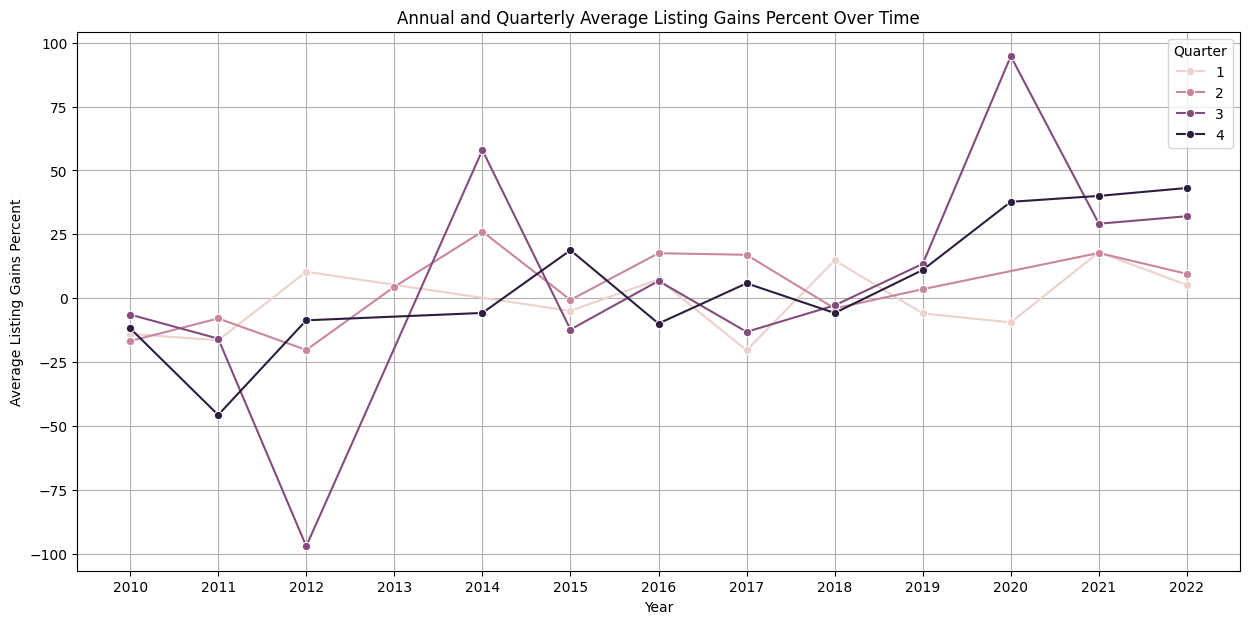

Annual and quarterly average Listing Gains Percent plotted.


In [21]:
plt.figure(figsize=(15, 7))
sns.lineplot(x='Year', y='Listing_Gains_Percent', hue='Quarter', data=annual_quarterly_avg_gains, marker='o')
plt.title('Annual and Quarterly Average Listing Gains Percent Over Time')
plt.xlabel('Year')
plt.ylabel('Average Listing Gains Percent')
plt.xticks(annual_quarterly_avg_gains['Year'].unique())
plt.grid(True)
plt.legend(title='Quarter')
plt.show()

print("Annual and quarterly average Listing Gains Percent plotted.")

**Reasoning**:
I will calculate the average of each subscription column grouped by 'Year' and 'Quarter', and then generate separate line plots for each to visualize their trends over time, as requested by the subtask.




--- Annual and Quarterly Average Subscription Rates ---

Subscription_QIB:
   Year  Quarter  Subscription_QIB
0  2010        1         30.260000
1  2010        2         21.263636
2  2010        3          7.914444
3  2010        4         12.080000
4  2011        1          3.978571


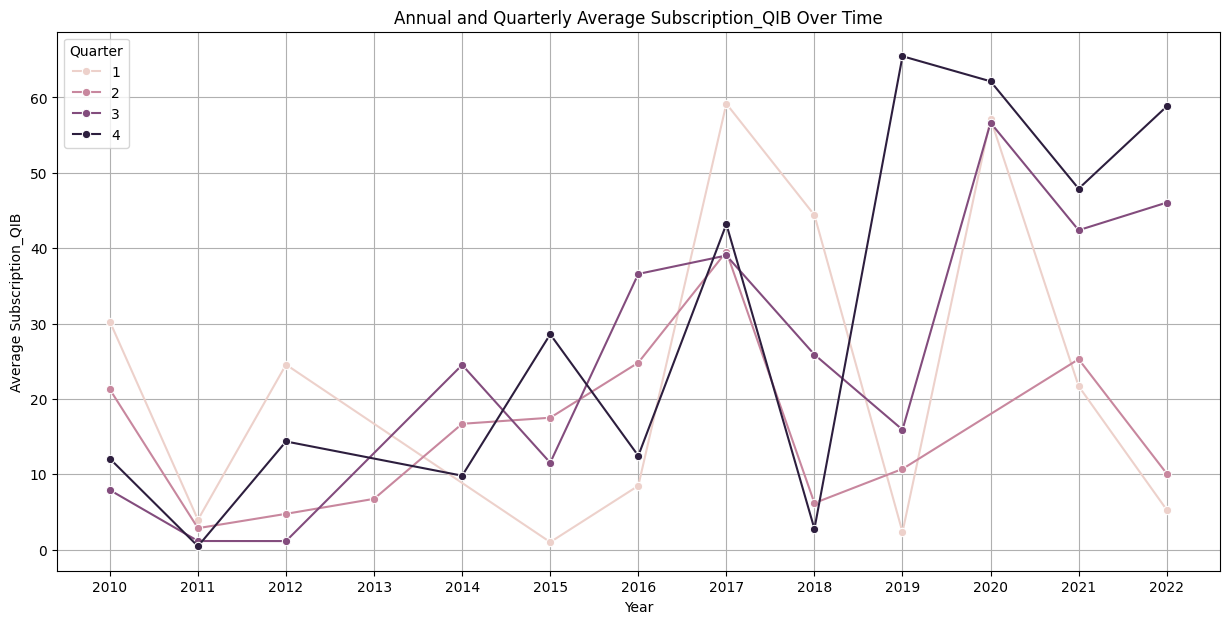


Subscription_HNI:
   Year  Quarter  Subscription_HNI
0  2010        1         53.792000
1  2010        2         23.240000
2  2010        3         26.173333
3  2010        4         32.062400
4  2011        1         16.567143


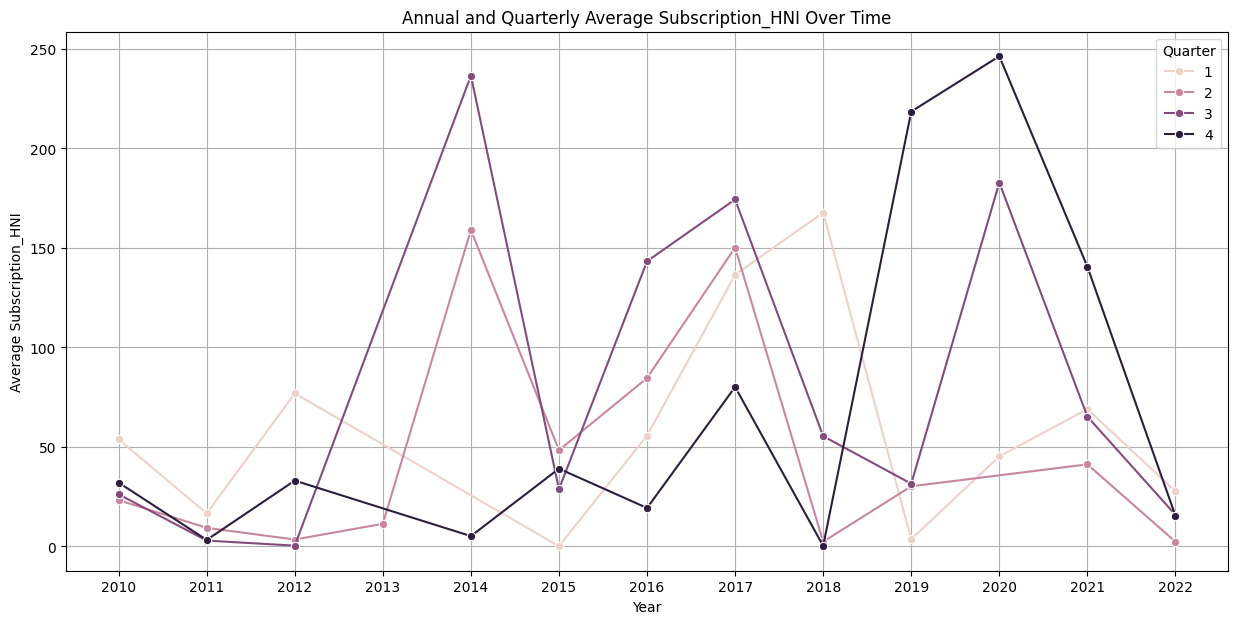


Subscription_RII:
   Year  Quarter  Subscription_RII
0  2010        1          6.508667
1  2010        2          5.968182
2  2010        3          5.094444
3  2010        4          7.214000
4  2011        1          6.371429


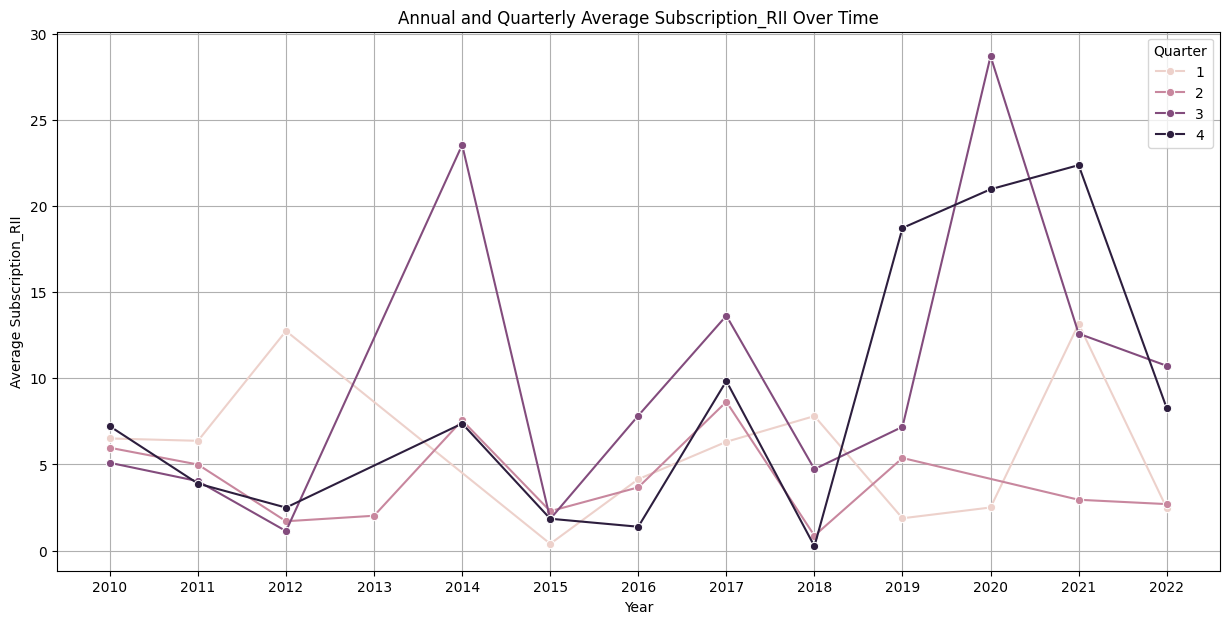


Subscription_Total:
   Year  Quarter  Subscription_Total
0  2010        1           23.863333
1  2010        2           15.922727
2  2010        3            9.191111
3  2010        4           13.610000
4  2011        1            6.965714


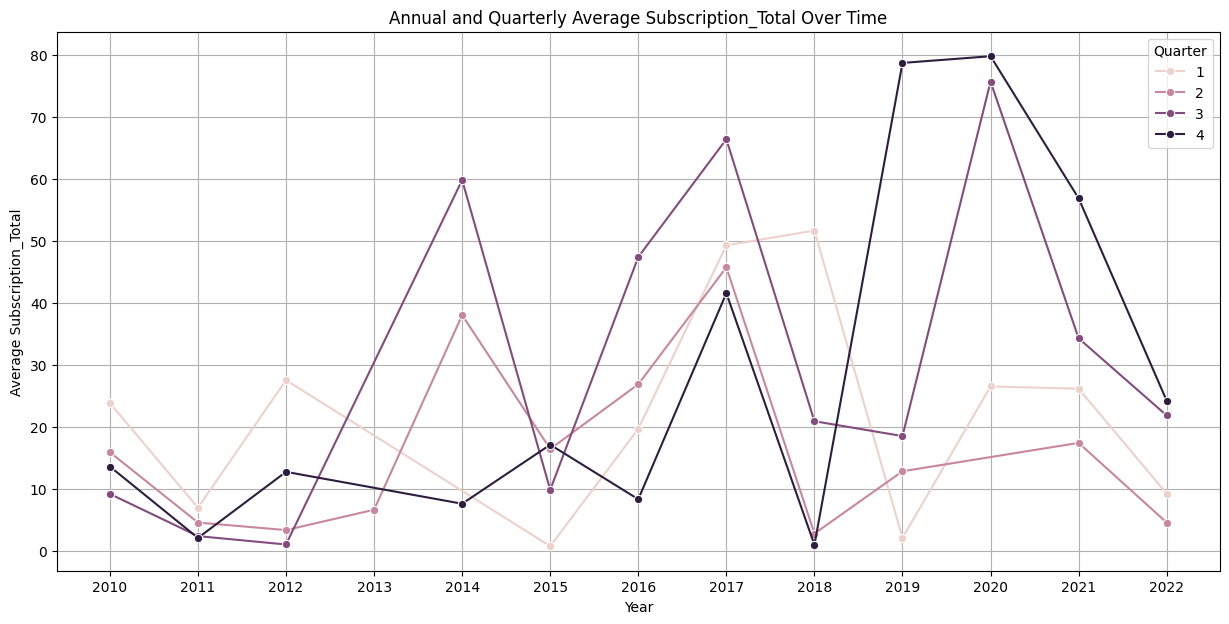

Annual and quarterly average subscription rates plotted for all specified columns.


In [22]:
subscription_columns = [
    'Subscription_QIB',
    'Subscription_HNI',
    'Subscription_RII',
    'Subscription_Total'
]

print("\n--- Annual and Quarterly Average Subscription Rates ---")
for col in subscription_columns:
    annual_quarterly_avg_subscription = df.groupby(['Year', 'Quarter'])[col].mean().reset_index()
    print(f"\n{col}:")
    print(annual_quarterly_avg_subscription.head())

    plt.figure(figsize=(15, 7))
    sns.lineplot(x='Year', y=col, hue='Quarter', data=annual_quarterly_avg_subscription, marker='o')
    plt.title(f'Annual and Quarterly Average {col} Over Time')
    plt.xlabel('Year')
    plt.ylabel(f'Average {col}')
    plt.xticks(annual_quarterly_avg_subscription['Year'].unique())
    plt.grid(True)
    plt.legend(title='Quarter')
    plt.show()

print("Annual and quarterly average subscription rates plotted for all specified columns.")

count    319.000000
mean      27.447147
std       48.772203
min        0.000000
25%        1.645000
50%        4.930000
75%       33.395000
max      326.490000
Name: Subscription_Total, dtype: float64


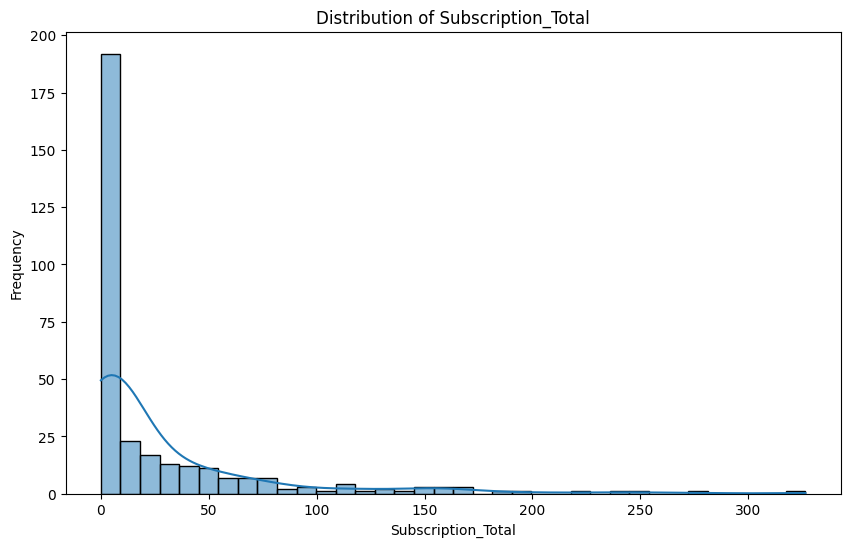

In [23]:
print(df['Subscription_Total'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df['Subscription_Total'], kde=True)
plt.title('Distribution of Subscription_Total')
plt.xlabel('Subscription_Total')
plt.ylabel('Frequency')
plt.show()

**Reasoning**:
Based on the descriptive statistics and histogram of 'Subscription_Total', I will define three tiers (Low, Medium, High) using the 25th and 75th percentiles as thresholds and create a new 'Subscription_Tier' column in the DataFrame, as per the subtask instructions.



In [24]:
low_threshold = df['Subscription_Total'].quantile(0.25)
medium_threshold = df['Subscription_Total'].quantile(0.75)

def categorize_subscription(total_subscription):
    if total_subscription <= low_threshold:
        return 'Low'
    elif total_subscription <= medium_threshold:
        return 'Medium'
    else:
        return 'High'

df['Subscription_Tier'] = df['Subscription_Total'].apply(categorize_subscription)

print("Subscription_Tier column created and its value counts:")
print(df['Subscription_Tier'].value_counts())
print(f"\nThresholds used: Low <= {low_threshold:.2f}, Medium > {low_threshold:.2f} and <= {medium_threshold:.2f}, High > {medium_threshold:.2f}")

Subscription_Tier column created and its value counts:
Subscription_Tier
Medium    159
High       80
Low        80
Name: count, dtype: int64

Thresholds used: Low <= 1.65, Medium > 1.65 and <= 33.39, High > 33.39


In [25]:
tier_analysis = df.groupby('Subscription_Tier').agg(
    profit_percentage=('Listing_Gains_Profit', lambda x: (x == 1).mean() * 100),
    average_listing_gains=('Listing_Gains_Percent', 'mean')
).reset_index()

print("Analysis by Subscription Tier:")
print(tier_analysis.round(2))

Analysis by Subscription Tier:
  Subscription_Tier  profit_percentage  average_listing_gains
0              High              80.00                  36.11
1               Low              31.25                  -9.28
2            Medium              53.46                  -3.98


/tmp/ipython-input-3504829421.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


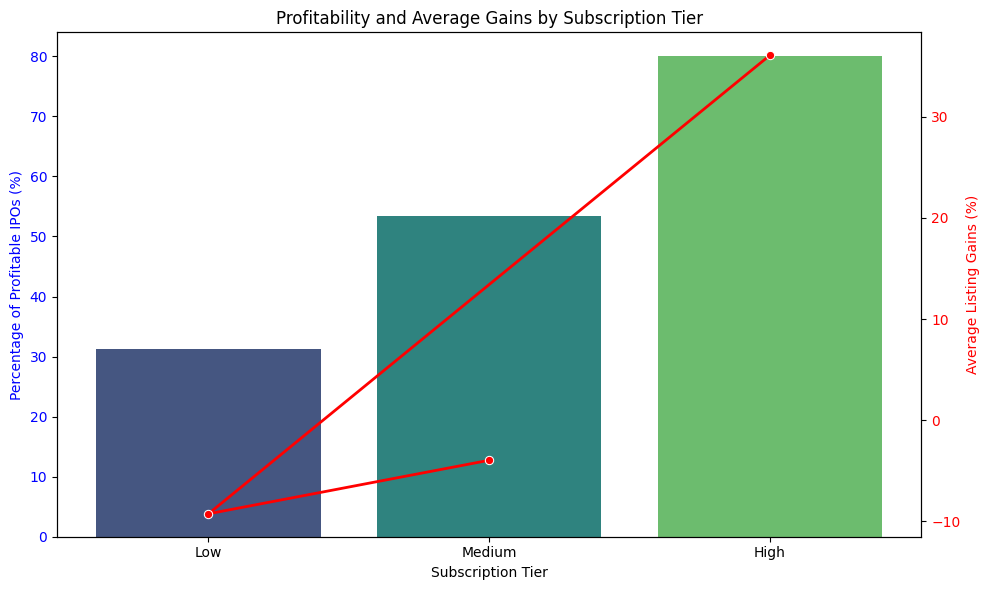

Combined plot of profitability and average listing gains by Subscription Tier generated.


In [26]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for profit_percentage
sns.barplot(
    x='Subscription_Tier',
    y='profit_percentage',
    data=tier_analysis,
    ax=ax1,
    palette='viridis',
    order=['Low', 'Medium', 'High']
)
ax1.set_title('Profitability and Average Gains by Subscription Tier')
ax1.set_xlabel('Subscription Tier')
ax1.set_ylabel('Percentage of Profitable IPOs (%)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for average_listing_gains
ax2 = ax1.twinx()
sns.lineplot(
    x='Subscription_Tier',
    y='average_listing_gains',
    data=tier_analysis,
    ax=ax2,
    color='red',
    marker='o',
    sort=False,
    linewidth=2
)
ax2.set_ylabel('Average Listing Gains (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

print("Combined plot of profitability and average listing gains by Subscription Tier generated.")

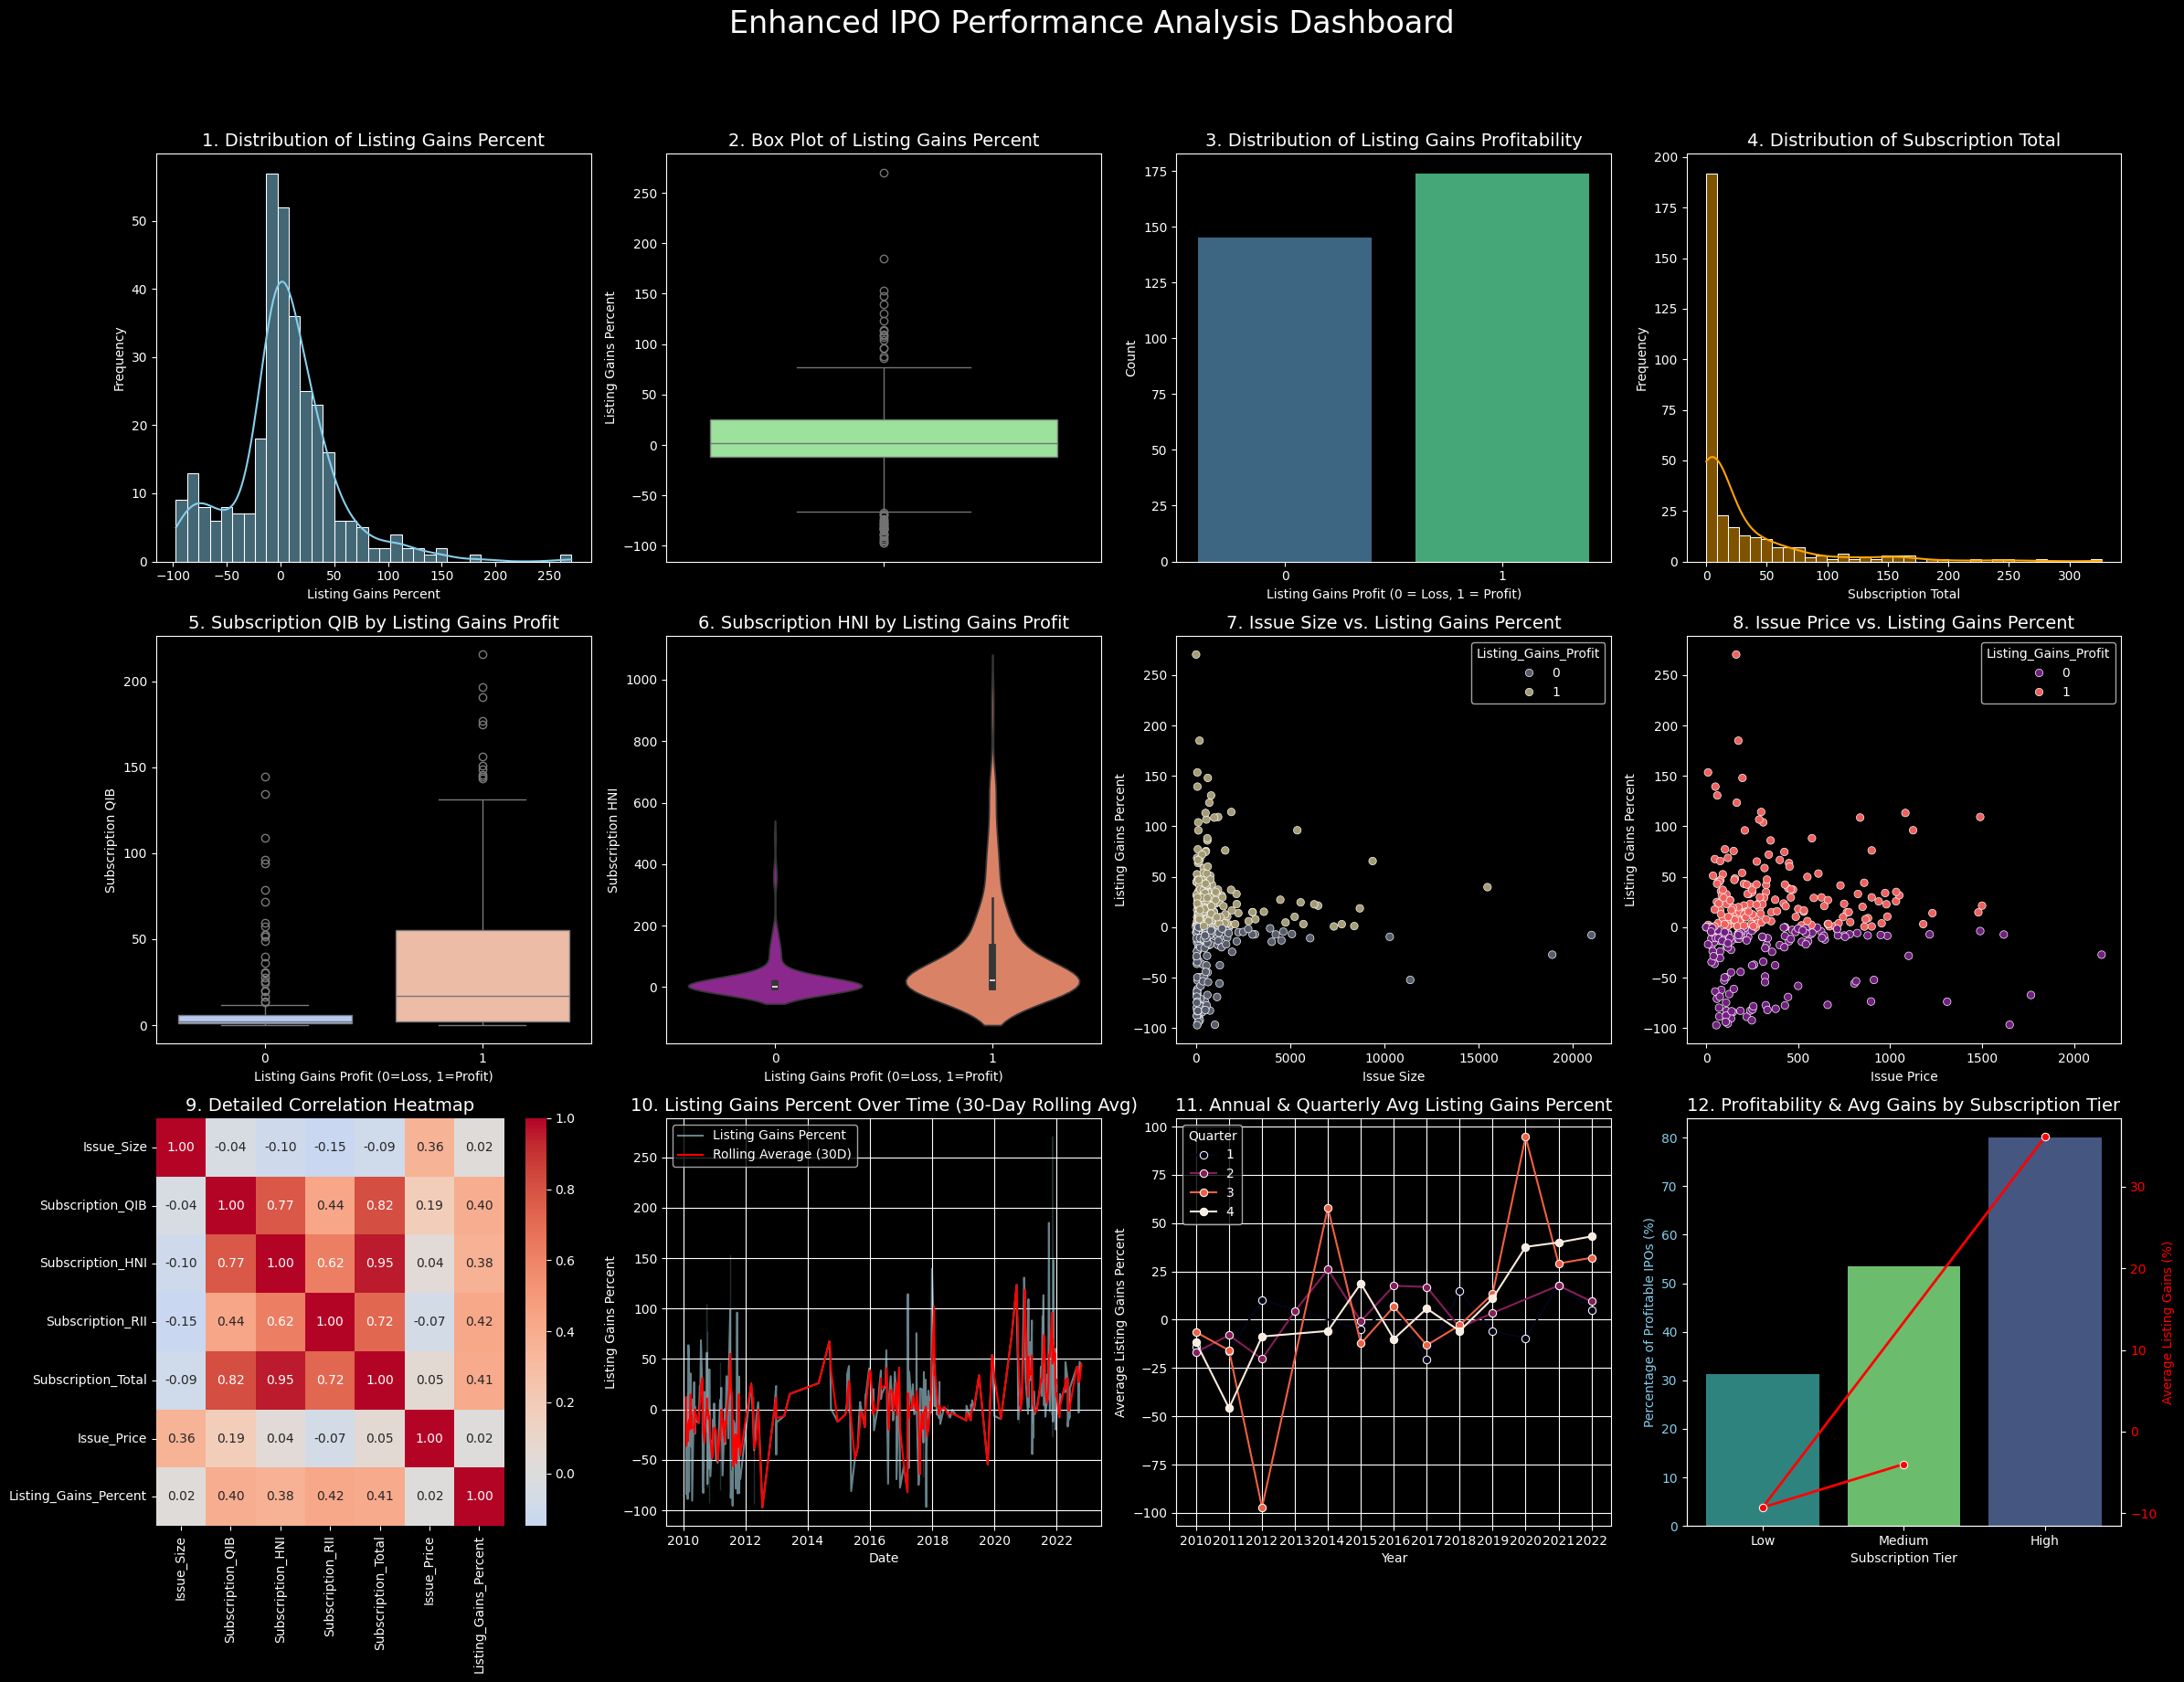

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 18))
fig.suptitle('Enhanced IPO Performance Analysis Dashboard', fontsize=24, y=1.02)

# Plot 1: Histogram of Listing_Gains_Percent
sns.histplot(df['Listing_Gains_Percent'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('1. Distribution of Listing Gains Percent', fontsize=14)
axes[0, 0].set_xlabel('Listing Gains Percent')
axes[0, 0].set_ylabel('Frequency')

# Plot 2: Box plot of Listing_Gains_Percent
sns.boxplot(y=df['Listing_Gains_Percent'], ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('2. Box Plot of Listing Gains Percent', fontsize=14)
axes[0, 1].set_ylabel('Listing Gains Percent')

# Plot 3: Count plot of Listing_Gains_Profit
sns.countplot(x='Listing_Gains_Profit', data=df, ax=axes[0, 2], palette='viridis', hue='Listing_Gains_Profit', legend=False)
axes[0, 2].set_title('3. Distribution of Listing Gains Profitability', fontsize=14)
axes[0, 2].set_xlabel('Listing Gains Profit (0 = Loss, 1 = Profit)')
axes[0, 2].set_ylabel('Count')

# Plot 4: Histogram of Subscription_Total
sns.histplot(df['Subscription_Total'], kde=True, ax=axes[0, 3], color='orange')
axes[0, 3].set_title('4. Distribution of Subscription Total', fontsize=14)
axes[0, 3].set_xlabel('Subscription Total')
axes[0, 3].set_ylabel('Frequency')

# Plot 5: Box plot of Subscription_QIB by Listing_Gains_Profit
sns.boxplot(x='Listing_Gains_Profit', y='Subscription_QIB', data=df, ax=axes[1, 0], palette='coolwarm', hue='Listing_Gains_Profit', legend=False)
axes[1, 0].set_title('5. Subscription QIB by Listing Gains Profit', fontsize=14)
axes[1, 0].set_xlabel('Listing Gains Profit (0=Loss, 1=Profit)')
axes[1, 0].set_ylabel('Subscription QIB')

# Plot 6: Violin plot of Subscription_HNI by Listing_Gains_Profit
sns.violinplot(x='Listing_Gains_Profit', y='Subscription_HNI', data=df, ax=axes[1, 1], palette='plasma', hue='Listing_Gains_Profit', legend=False)
axes[1, 1].set_title('6. Subscription HNI by Listing Gains Profit', fontsize=14)
axes[1, 1].set_xlabel('Listing Gains Profit (0=Loss, 1=Profit)')
axes[1, 1].set_ylabel('Subscription HNI')

# Plot 7: Scatter plot of Issue_Size vs. Listing_Gains_Percent
sns.scatterplot(x='Issue_Size', y='Listing_Gains_Percent', hue='Listing_Gains_Profit', data=df, ax=axes[1, 2], palette='cividis')
axes[1, 2].set_title('7. Issue Size vs. Listing Gains Percent', fontsize=14)
axes[1, 2].set_xlabel('Issue Size')
axes[1, 2].set_ylabel('Listing Gains Percent')

# Plot 8: Scatter plot of Issue_Price vs. Listing_Gains_Percent
sns.scatterplot(x='Issue_Price', y='Listing_Gains_Percent', hue='Listing_Gains_Profit', data=df, ax=axes[1, 3], palette='magma')
axes[1, 3].set_title('8. Issue Price vs. Listing Gains Percent', fontsize=14)
axes[1, 3].set_xlabel('Issue Price')
axes[1, 3].set_ylabel('Listing Gains Percent')

# Plot 9: Correlation Heatmap of Numerical Features and Listing Gains Percent
sns.heatmap(
    correlation_matrix_detailed,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",
    ax=axes[2, 0]
)
axes[2, 0].set_title('9. Detailed Correlation Heatmap', fontsize=14)

# Plot 10: Listing Gains Percent Over Time with 30-Day Rolling Average
sns.lineplot(x='Date', y='Listing_Gains_Percent', data=df, label='Listing Gains Percent', ax=axes[2, 1], alpha=0.6, color='lightblue')
sns.lineplot(x='Date', y='Listing_Gains_Percent_Rolling_Avg', data=df, label='Rolling Average (30D)', color='red', ax=axes[2, 1])
axes[2, 1].set_title('10. Listing Gains Percent Over Time (30-Day Rolling Avg)', fontsize=14)
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Listing Gains Percent')
axes[2, 1].legend()
axes[2, 1].grid(True)

# Plot 11: Annual and Quarterly Average Listing_Gains_Percent
sns.lineplot(x='Year', y='Listing_Gains_Percent', hue='Quarter', data=annual_quarterly_avg_gains, marker='o', ax=axes[2, 2], palette='rocket')
axes[2, 2].set_title('11. Annual & Quarterly Avg Listing Gains Percent', fontsize=14)
axes[2, 2].set_xlabel('Year')
axes[2, 2].set_ylabel('Average Listing Gains Percent')
axes[2, 2].set_xticks(annual_quarterly_avg_gains['Year'].unique())
axes[2, 2].legend(title='Quarter')
axes[2, 2].grid(True)

# Plot 12: Combined bar and line plot of profitability and average gains by Subscription_Tier
sns.barplot(x='Subscription_Tier', y='profit_percentage', data=tier_analysis, ax=axes[2, 3], palette='viridis', order=['Low', 'Medium', 'High'], hue='Subscription_Tier', legend=False)
axes[2, 3].set_title('12. Profitability & Avg Gains by Subscription Tier', fontsize=14)
axes[2, 3].set_xlabel('Subscription Tier')
axes[2, 3].set_ylabel('Percentage of Profitable IPOs (%)', color='skyblue')
axes[2, 3].tick_params(axis='y', labelcolor='skyblue')

ax2_twin = axes[2, 3].twinx()
sns.lineplot(x='Subscription_Tier', y='average_listing_gains', data=tier_analysis, ax=ax2_twin, color='red', marker='o', sort=False, linewidth=2)
ax2_twin.set_ylabel('Average Listing Gains (%)', color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')

plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle
plt.show()

plt.style.use('default') # Reset style to default
